# Laboratorio N°2 - Computación Científica II - ILI286


**Autores**:
+ Ariel Sanhueza Román - asanhuez@alumnos.inf.utfsm.cl - 201173005-4 
+ Gonzalo Moya Rodríguez - gemoya@alumnos.inf.utfsm.cl - 201173016-k

# Introducción

# Previo
Primero, importaremos las bibliotecas previas:

In [166]:
import numpy as np
from scipy import linalg
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm, solve
#%load_ext memory_profiler
from scipy.special import gamma
from sympy import *
import time
#from sympy.mpmath import diff

# Desarrollo

## Integración impropia

### Pregunta 1
Primero, separaremos la integral en dos partes:
\begin{align*}
    \int_{-\infty}^x \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt 
    &= \int_{-\infty}^0 \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt + \int_{0}^x \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt
\end{align*}

La segunda integral no genera problemas de indefinición. Para la primera, por temas de orden, realizaremos dos cambios de variables. Sea $u = \frac{1}{t+1} \rightarrow dt = \frac{-1}{u^2}du$, entonces tenemos:
\begin{align*}
    \int_{-\infty}^0 \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt &= \int_0^1 \frac{-1}{\sqrt{2\pi}} e^{\frac{-(1-u)^2}{2u^2}}\frac{1}{u^2}du
\end{align*}

Ahora, para dejar el intervalo en $[a,b]$, realizaremos el cambio $w = a + (b-a)u \rightarrow dw = (b-a)du$, quedando finalmente:

\begin{align*}
    \int_0^1 \frac{-1}{\sqrt{2\pi}} e^{\frac{-(1-u)^2}{2u^2}}\frac{1}{u^2}du &= \int_a^b \frac{1}{\sqrt{2\pi}} e^{\frac{-(b-w)^2}{2(w-a)^2}} \frac{(b-a)}{(w-a)^2} dw
\end{align*}

Ahora, la segunda integral no tiene problemas de indefinición, pero sí problemas numéricos de aproximación y error, por lo que se le aplicará también el primer cambio para resolverlos. Así, finalmente queda:

\begin{align*}
    \int_{-\infty}^x \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt 
    &= \int_a^b \frac{1}{\sqrt{2\pi}} e^{\frac{-(b-w)^2}{2(w-a)^2}} \frac{(b-a)}{(w-a)^2} dw + \int_{1}^{\frac{1}{x+1}} \frac{-1}{\sqrt{2\pi}} e^{-\frac{(1-u)^2}{2u^2}} \frac{1}{u^2}dt
\end{align*}

### Pregunta 2

Para la implementación, utilizaremos los algoritmos implementados en clases.


In [40]:
def midpoint(myfun, N, a, b):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points  
    dx = x[1]-x[0]
    midpoints = x[:-1] + .5*dx
    midpoint_values = f(midpoints)
    int_val = sum(midpoint_values*dx)
    return int_val

Para "midpoint rule" tenemos que el costo computacional, en función de $N$, es de $O(N)$ (evaluación en $N+1$ puntos).

In [75]:
def trapezoid(myfun, N, a, b):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points  
    h = x[1]-x[0]
    xmiddle = x[1:-1]
    int_val = 0.5*h*sum(f(x[0])+2*f(xmiddle)+f(x[-1]))
    return int_val

Para "trapezoid rule", la complejidad es $O(N)$, pues también se ejecutan $N+1$ evaluaciones.

In [76]:
def simpsons(myfun, N, a, b):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points
    if N%2==1:
        print("Simpsons rule only applicable to even number of segments")
        return
    dx = x[1]-x[0]
    xleft   = x[:-2:2]
    xmiddle = x[1::2]
    xright  = x[2::2]
    int_val = sum((f(xleft)+4*f(xmiddle)+f(xright))*dx/3)
    return int_val

Para "Simpsons rule", también se tiene $O(N)$, pues se evalúan $N-1$ puntos (entre los extremos).

In [77]:
def gaussianquad(myfun, N, a, b):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x, w = gaussian_nodes_and_weights(N, a, b)
    int_val = sum( w * f(x) )
    return int_val

def gaussian_nodes_and_weights(N, a, b):
    if N==1: return np.array([1]), np.array([2])
    beta = .5 / np.sqrt(1.-(2.*np.arange(1.,N))**(-2))
    T = np.diag(beta,1) + np.diag(beta,-1)
    D, V = np.linalg.eigh(T)
    x = D
    x = .5 * ( (b-a)*x + b + a) # Rescaling
    w = 2*V[0,:]**2
    w = .5*(b-a)*w
    return x, w

Para "Gaussian Quadrature", tenemos La evaluación de los $N$ puntos, pero tenemos también que encontrar los $x_i$ (que en el algoritmo usado, representan los valores propios de $T$) que es de complejidad $O(m^3)$ con $m$ tamaño de la matriz cuadrada, entonces la complejidad es $O(N + m^3) = O(m^3) = O(N^3)$.

### Pregunta 3
Primero, definimos nuestra función y parámetros. Es importante mencionar que, dado que $\frac{1}{\sqrt{2\pi}}$ es constante y aparece en todos los cálculos, se sacó de la integral para ahorrar cómputos. También es importante destacar que:
* $f_1$ es la expresión con cambio de variables.
* $f_2$ es la expresión que va desde 0 a $x$.

In [180]:
# Intervalos
a = 0.
b = 1.

# Función y constantes
cons = 1./np.sqrt(2.*np.pi)
f1 = lambda w: np.exp(-0.5*((b-w)/(w-a))**2) * (b-a)/(w-a)**2
f2 = lambda t: np.exp(-0.5*t**2)
f3 = lambda u: -np.exp(-0.5*((1-u)/u)**2)/u**2
repeat = 100

# Puntos
points = np.logspace(0,49)

def get_data(f1, points, f2 = None, method = 'mp', type = ''):
    data = []
    if method == 'mp':
        func = midpoint
    elif method == 'trap':
        func = trapezoid
    elif method == 'simp':
        func = simpsons
    else:
        func = gaussianquad
    
    if type == '':
        for i in range(len(points)):
            data.append(cons*func(f1,N,a,b) + cons*func(f2,N,1,1/(points[i]+1)))
    else:
        for i in range(len(points)):
            T = 0
            for j in range(repeat):
                start = time.time()
                cons*func(f1,N,a,b) + cons*func(f2,N,1,1/(points[i]+1))
                end = time.time()
                T += (end-start)*1000
            data.append(T/repeat)
    return data

Debido al cambio usado, el método de Simpsons y del Trapezoide no funcionan debido a que la transformación se indefine en el parámetro $a$ y estos dos métodos evalúan las funciones en sus extremos por lo que mostraremos los gráficos asociados a los métodos que sí funcionan.

Primero, los gráficos asociados al cálculo de la integral para distintos N

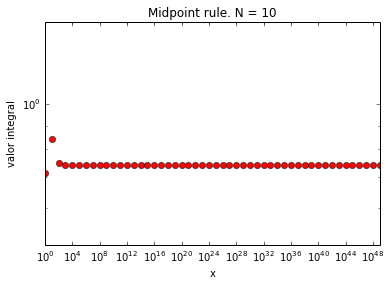

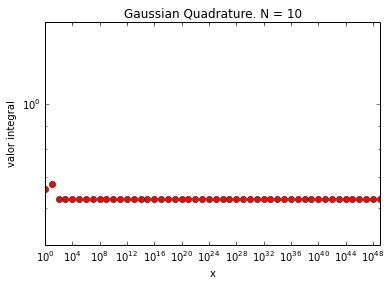

In [161]:
# Midpoint rule
N = 2
plt.loglog(points, get_data(f1, points, f3, 'mp'), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Midpoint rule. N = 2")
plt.ylim([0.5, 1.5])
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, ''), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Gaussian Quadrature. N = 2")
plt.ylim([0.5, 1.5])
plt.show()

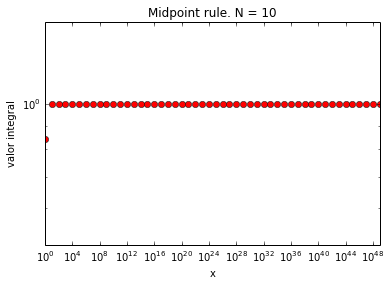

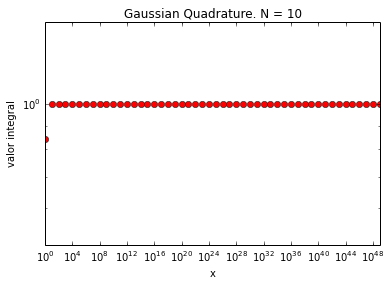

In [164]:
# Midpoint rule
N = 10
plt.loglog(points, get_data(f1, points, f3, 'mp'), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Midpoint rule. N = 10")
plt.ylim([0.5, 1.5])
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, ''), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Gaussian Quadrature. N = 10")
plt.ylim([0.5, 1.5])
plt.show()

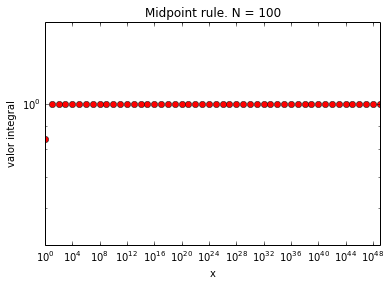

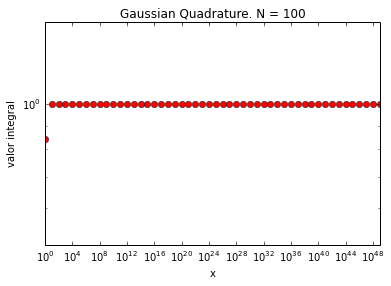

In [165]:
# Midpoint rule
N = 100
plt.loglog(points, get_data(f1, points, f3, 'mp'), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Midpoint rule. N = 100")
plt.ylim([0.5, 1.5])
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, ''), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Gaussian Quadrature. N = 100")
plt.ylim([0.5, 1.5])
plt.show()

Ahora, los gráficos de los tiempos de cómputo:

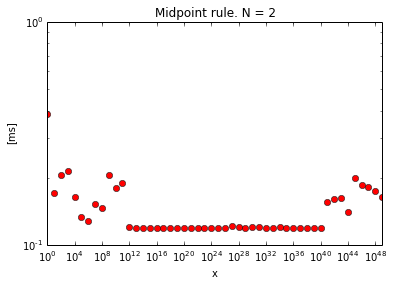

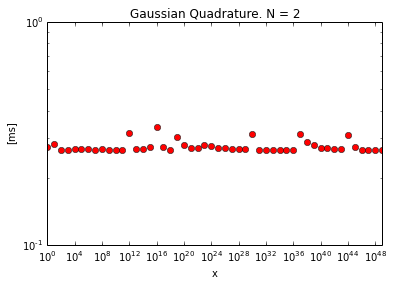

In [181]:
# Midpoint rule
N = 2
plt.loglog(points, get_data(f1, points, f3, 'mp', 't'), 'or')
plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Midpoint rule. N = 2")
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, '', 't'), 'or')

plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Gaussian Quadrature. N = 2")
plt.show()

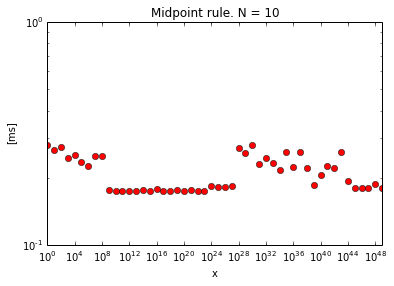

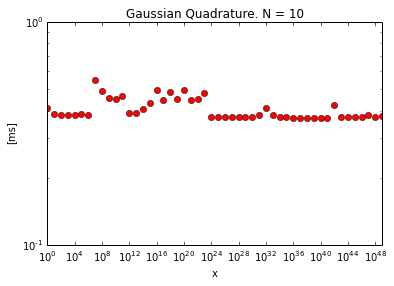

In [182]:
# Midpoint rule
N = 10
plt.loglog(points, get_data(f1, points, f3, 'mp', 't'), 'or')
plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Midpoint rule. N = 10")
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, '', 't'), 'or')

plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Gaussian Quadrature. N = 10")
plt.show()

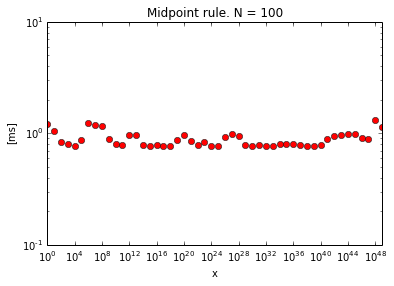

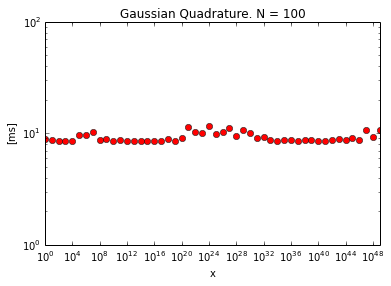

In [184]:
# Midpoint rule
N = 100
plt.loglog(points, get_data(f1, points, f3, 'mp', 't'), 'or')
plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Midpoint rule. N = 100")
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, '', 't'), 'or')

plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Gaussian Quadrature. N = 100")
plt.show()

### Pregunta 4
Para $x = 0$ no ocurre nada, pues el cero no indetermna la función (se podría aplicar sin cambio de variables). Esto se ve en el siguiente cálculo.

In [187]:
# Definimos x = 0, N = 1000 y calculamos la suma de las integrales (la segunda integral quedaría en 0, pues va de 0 a 0)
x = 0
N = 1000

int1 = cons*midpoint(f1,N,a,b)
int2 = cons*midpoint(f2,N,1,1/(x+1))
print "El resultado es: ", int1 + int2
print "Valor de la primera integral: ", int1
print "Valor de la segunda integral: ", int2

El resultado es:  0.500000033245
Valor de la primera integral:  0.500000033245
Valor de la segunda integral:  0.0


## The Caputo's Fractional Derivative

### Pregunta 1

Se realiza un cambio de variable considerando una recta que pasa por los puntos $(a,-1)$ y $(t,1)$, es decir, sea la ecuación de la recta la siguiente:
\begin{align*}
\frac{y-y_1}{\tau-\tau_1} = \frac{y_2-y_1}{\tau_2 - \tau_1}
\end{align*}
Haciendo los reemplazos correspondientes:
\begin{align*}
\frac{y+1}{\tau-a} = \frac{2}{t - a}
\end{align*}

\begin{align*}
(y+1)(t-a) = 2(\tau - a)
\end{align*}

\begin{align*}
\tau = \frac{(y+1)(t-a)}{2} + a 
\end{align*}
Luego el diferencial de $\tau$, $d\tau$ es:
\begin{align*}
d\tau = \frac{(t-a)}{2}dy
\end{align*}

Finalmente la integral queda como
\begin{align*}
\frac{1}{\Gamma{(1-\alpha})}\frac{(t-a)}{2}\int_{-1}^1 \frac{f'(\frac{(y+1)(t-a)}{2} + a )}{(t - \frac{(y+1)(t-a)}{2} -a)^{\alpha}}dy
\end{align*}

Pero operando sobre el denominador del argumento de la  integral se puede dejar como
\begin{align*}
\frac{1}{\Gamma{(1-\alpha})}{(\frac{(t-a)}{2})}^{1-\alpha}\int_{-1}^1 \frac{f'(\frac{(y+1)(t-a)}{2} + a )}{(1-y)^{\alpha}}dy
\end{align*}

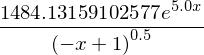

In [12]:
def diff_alpha(f,t,alpha,a=0):
    x=Symbol('x')
    k=Symbol('k')
    

    
    if alpha <1:
        f_prima = diff(f,x)
        denom = 1/((k-x)**alpha)
        g = f_prima*denom
        resultado = (1/gamma(1-alpha))*integrate(g,(x,0,k))

        resultado2 = resultado.subs(k,t).evalf()
        
        return resultado2
        
    else:
        alpha_int = int(alpha)
        alpha_float = alpha - alpha_int
        
        f_prima = diff(f,x)
        denom = 1/((k-x)**alpha_float)
        g = f_prima*denom
        resultado = (1/gamma(1-alpha_float))*integrate(g,(x,0,k))
        
        resultado = diff(resultado,k, alpha_int)
        resultado2 = resultado.subs(k,t).evalf()
        
        return resultado2
    
#print t
#print "implementacion : ", diff_alpha(lambda x: exp(x),t,0.5,a=0)
x = Symbol('x')
res = diff_alpha(sympify('log(x)'), pi, 0.6, a=0)


In [ ]:
res1 = diff_alpha(sympify(20), 1, 0.2, a=0)
for i in np.arange(0,1,0.1):
    print diff_alpha(sympify(20), 1, i, a=0)

In [ ]:
res2 = diff_alpha(sin(x), pi, 1, a=0)
for i in np.arange(1,2,0.1):
    print diff_alpha(sin(x), pi/4, i, a=0)

In [ ]:
res3 = diff_alpha(exp(x), 1, 46.4, a=0)
for i in np.arange(46,47,0.1):
    print diff_alpha(exp(x), 10, i, a=0)

In [ ]:
res4 = diff_alpha((x), 1, 0.7, a=0)
for i in np.arange(0,1,0.1):
    diff_alpha((x), 1, i, a=0)

In [ ]:
x = Symbol('x')
for i in np.arange(0.2,1,0.1):
    print diff_alpha(log(x), 2, i, a=0)

In [ ]:
res6 = diff_alpha(x**2, 100, 0.5, a=0)

In [130]:
x=Symbol('x')
k=Symbol('k')

f = exp(x)
f_prima = diff(f,x)
denom = 1/((k - x)**0.5)
g = f_prima*denom 

i = integrate(g,(x,k,0))

In [136]:
ip = diff(i, k)
print ip.subs(k)

zoo*exp(k) + Integral(-0.5*(k - x)**(-1.5)*exp(x), (x, k, 0))


In [ ]:
x,y,z=symbols('x y z')
init_printing(use_unicode=True)
t=10
a=0
alpha=0.5
#y=(2*x-t-a)/(t-a)

y_y=((x+1)*(t-a))/2.0 + a
j = ((t-a)/2.0)**(1-alpha)
#denom = 1/(1-x)**(alpha)
denom = 1/(t - ((x+1)*(t-a)/2.0) - a)**alpha

funcion=diff(exp(y_y),x)*denom
f_1 = lambda t: funcion.evalf(subs={x: t})
# la derivada esta bien e incluye lo que bota la regla de la cadena
# es decir dy=algo*dx

#print diff(exp(y_y),x)
#print f_1(0.)
#print funcion.evalf(subs={x:0.0})
print f_1
#print lambda x: funcion.doit()
print (1/gamma(1-alpha))*gaussianquad(f_1, 1000, -1, 1)
#print np.vectorize(funcion)
#print funcion

#f = np.vectorize(lambda l: funcion) # So we can apply it to arrays without trouble
#print f
#lala, w = gaussian_nodes_and_weights(10, -1, 1)
#int_val = sum( w * f(lala))
#print int_val